<a href="https://colab.research.google.com/github/ardakaykusuz/ardakaykusuz/blob/main/Text_Mining_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing liberaries and datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df_train = pd.read_csv(r"/content/train.csv")
df_test = pd.read_csv(r"/content/test.csv")

# Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def raw_corpus_analysis(df, text_column="text", dataset_name="Corpus"):
    """
    Comprehensive EDA on raw text data before any preprocessing.

    Parameters:
    - df: pandas DataFrame containing the text data.
    - text_column: column name in df to analyze.
    - dataset_name: label for charts and printouts.
    """

    print(f"=== {dataset_name.upper()} RAW DATA ANALYSIS ({text_column}) ===")

    # Basic dataset info
    print(f"\nDataset Overview:")
    print(f"Total documents: {len(df):,}")
    print(f"Missing texts: {df[text_column].isna().sum():,}")
    print(f"Empty texts: {(df[text_column].fillna('') == '').sum():,}")
    print(f"Duplicate texts: {df[text_column].duplicated().sum():,}")

    # Clean valid texts
    df_clean = df[df[text_column].notna() & (df[text_column] != '')].copy()
    df_clean['char_count'] = df_clean[text_column].str.len()
    df_clean['word_count'] = df_clean[text_column].str.split().str.len()
    df_clean['sentence_count'] = df_clean[text_column].str.count(r'[.!?]+') + 1

    # [Keep the rest of your code the same, but replace every occurrence of `df['text']` with `df[text_column]` and so on accordingly.]
    # Example: use df_clean[text_column] instead of df_clean['text']


    print(f"\nText Length Statistics:")
    print(f"Characters - Mean: {df_clean['char_count'].mean():.1f}, Median: {df_clean['char_count'].median():.1f}")
    print(f"Words - Mean: {df_clean['word_count'].mean():.1f}, Median: {df_clean['word_count'].median():.1f}")
    print(f"Sentences - Mean: {df_clean['sentence_count'].mean():.1f}, Median: {df_clean['sentence_count'].median():.1f}")

    # Content analysis
    print(f"\nContent Analysis:")

    # URLs
    url_count = df_clean[text_column].str.count(r'http[s]?://\S+').sum()
    docs_with_urls = (df_clean[text_column].str.contains(r'http[s]?://\S+', na=False)).sum()
    print(f"URLs: {url_count:,} total in {docs_with_urls:,} documents ({docs_with_urls/len(df_clean)*100:.1f}%)")

    # Mentions and hashtags
    mention_count = df_clean[text_column].str.count(r'@\w+').sum()
    hashtag_count = df_clean[text_column].str.count(r'#\w+').sum()
    print(f"Mentions (@): {mention_count:,}")
    print(f"Hashtags (#): {hashtag_count:,}")

    # Financial symbols
    ticker_count = df_clean[text_column].str.count(r'\$[A-Z]{1,5}\b').sum()
    docs_with_tickers = (df_clean[text_column].str.contains(r'\$[A-Z]{1,5}\b', na=False)).sum()
    print(f"Stock tickers ($): {ticker_count:,} in {docs_with_tickers:,} documents ({docs_with_tickers/len(df_clean)*100:.1f}%)")

    # Numbers and currency
    number_count = df_clean[text_column].str.count(r'\d+').sum()
    currency_count = df_clean[text_column].str.count(r'[\$€£¥]\d+').sum()
    print(f"Numbers: {number_count:,}")
    print(f"Currency amounts: {currency_count:,}")

    # Special characters
    special_char_count = df_clean[text_column].str.count(r'[^\w\s]').sum()
    print(f"Special characters: {special_char_count:,}")

    # Language indicators
    all_caps_count = df_clean[text_column].str.count(r'\b[A-Z]{2,}\b').sum()
    print(f"All-caps words: {all_caps_count:,}")

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{dataset_name} - Raw Data Distributions', fontsize=16, fontweight='bold')

    # 1. Character count distribution
    axes[0,0].hist(df_clean['char_count'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Character Count Distribution')
    axes[0,0].set_xlabel('Characters')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(df_clean['char_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["char_count"].mean():.0f}')
    axes[0,0].legend()

    # 2. Word count distribution
    axes[0,1].hist(df_clean['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Word Count Distribution')
    axes[0,1].set_xlabel('Words')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(df_clean['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["word_count"].mean():.1f}')
    axes[0,1].legend()

    # 3. Sentence count distribution
    axes[0,2].hist(df_clean['sentence_count'], bins=20, alpha=0.7, color='coral', edgecolor='black')
    axes[0,2].set_title('Sentence Count Distribution')
    axes[0,2].set_xlabel('Sentences')
    axes[0,2].set_ylabel('Frequency')

    # 4. Content type distribution
    content_types = {
        'With URLs': docs_with_urls,
        'With Tickers': docs_with_tickers,
        'With Mentions': (df_clean[text_column].str.contains(r'@\w+', na=False)).sum(),
        'With Hashtags': (df_clean[text_column].str.contains(r'#\w+', na=False)).sum()
    }
    axes[1,0].bar(content_types.keys(), content_types.values(), alpha=0.7, color='purple')
    axes[1,0].set_title('Documents by Content Type')
    axes[1,0].set_ylabel('Document Count')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 5. Text length categories
    df_clean['length_category'] = pd.cut(df_clean['char_count'],
                                       bins=[0, 50, 100, 200, 500, float('inf')],
                                       labels=['Very Short (<50)', 'Short (50-100)',
                                              'Medium (100-200)', 'Long (200-500)',
                                              'Very Long (>500)'])
    length_dist = df_clean['length_category'].value_counts()
    axes[1,1].pie(length_dist.values, labels=length_dist.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Text Length Categories')

    # 6. Box plot of word counts by length category
    axes[1,2].boxplot([df_clean[df_clean['length_category'] == cat]['word_count'].values
                      for cat in length_dist.index],
                     labels=[cat.split()[0] for cat in length_dist.index])
    axes[1,2].set_title('Word Count by Length Category')
    axes[1,2].set_xlabel('Length Category')
    axes[1,2].set_ylabel('Word Count')
    axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Word frequency analysis (top words in raw text)
    print(f"\n=== RAW VOCABULARY ANALYSIS ===")
    all_words = []
    for text in df_clean[text_column]:
        words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
        all_words.extend(words)

    word_freq = Counter(all_words)
    total_words = len(all_words)
    unique_words = len(word_freq)

    print(f"Total words: {total_words:,}")
    print(f"Unique words: {unique_words:,}")
    print(f"Vocabulary richness: {unique_words/total_words:.3f}")

    print(f"\nTop 20 Most Frequent Words:")
    for word, count in word_freq.most_common(20):
        print(f"  {word}: {count:,} ({count/total_words*100:.2f}%)")

    # Financial-specific analysis
    print(f"\n=== FINANCIAL CONTENT ANALYSIS ===")

    # Extract stock tickers
    tickers = []
    for text in df_clean[text_column]:
        found_tickers = re.findall(r'\$([A-Z]{1,5})\b', text)
        tickers.extend(found_tickers)

    if tickers:
        ticker_freq = Counter(tickers)
        print(f"Most mentioned tickers:")
        for ticker, count in ticker_freq.most_common(10):
            print(f"  ${ticker}: {count:,}")

    # Financial keywords
    financial_keywords = ['earnings', 'revenue', 'profit', 'loss', 'buy', 'sell',
                         'bullish', 'bearish', 'market', 'stock', 'price', 'trade']
    keyword_counts = {}
    for keyword in financial_keywords:
        count = sum(df_clean[text_column].str.lower().str.count(keyword))
        if count > 0:
            keyword_counts[keyword] = count

    if keyword_counts:
        print(f"\nFinancial keyword frequency:")
        for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {keyword}: {count:,}")

    # Data quality indicators
    print(f"\n=== DATA QUALITY INDICATORS ===")

    # Very short texts (potential noise)
    very_short = (df_clean['char_count'] < 20).sum()
    print(f"Very short texts (<20 chars): {very_short:,} ({very_short/len(df_clean)*100:.1f}%)")

    # Very long texts (potential concatenated content)
    very_long = (df_clean['char_count'] > 500).sum()
    print(f"Very long texts (>500 chars): {very_long:,} ({very_long/len(df_clean)*100:.1f}%)")

    # Texts with excessive punctuation
    punct_heavy = df_clean[text_column].str.count(r'[^\w\s]') / df_clean['char_count']
    excessive_punct = (punct_heavy > 0.3).sum()
    print(f"Punctuation-heavy texts (>30%): {excessive_punct:,} ({excessive_punct/len(df_clean)*100:.1f}%)")

    # Return summary statistics
    summary_stats = {
        'total_docs': len(df),
        'valid_docs': len(df_clean),
        'avg_chars': df_clean['char_count'].mean(),
        'avg_words': df_clean['word_count'].mean(),
        'total_vocabulary': unique_words,
        'docs_with_urls': docs_with_urls,
        'docs_with_tickers': docs_with_tickers,
        'most_common_words': word_freq.most_common(10)
    }

    return df_clean, summary_stats

=== CORPUS RAW DATA ANALYSIS (text) ===

Dataset Overview:
Total documents: 9,543
Missing texts: 0
Empty texts: 0
Duplicate texts: 0

Text Length Statistics:
Characters - Mean: 85.8, Median: 79.0
Words - Mean: 12.2, Median: 11.0
Sentences - Mean: 2.0, Median: 2.0

Content Analysis:
URLs: 5,095 total in 4,470 documents (46.8%)
Mentions (@): 347
Hashtags (#): 2,182
Stock tickers ($): 2,008 in 1,425 documents (14.9%)
Numbers: 13,950
Currency amounts: 1,292
Special characters: 54,122
All-caps words: 6,912


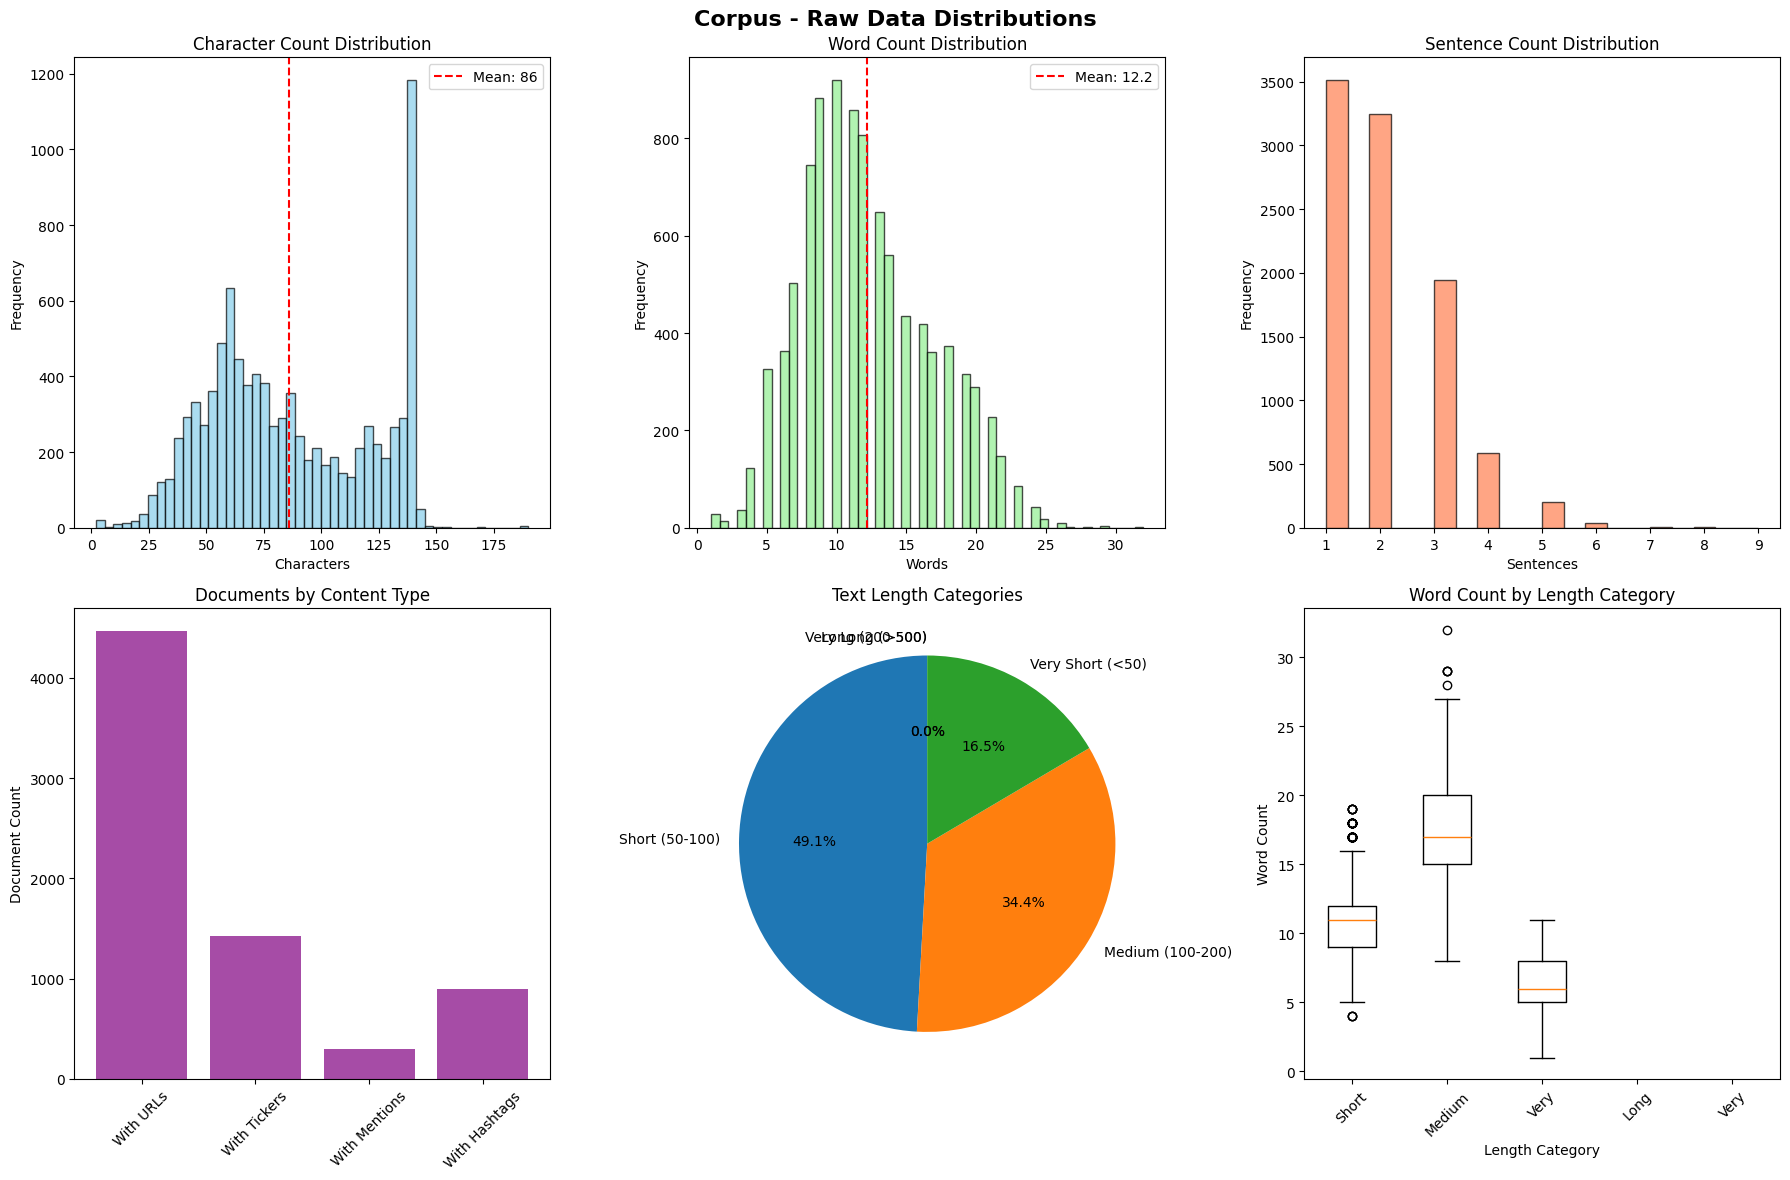


=== RAW VOCABULARY ANALYSIS ===
Total words: 124,480
Unique words: 15,657
Vocabulary richness: 0.126

Top 20 Most Frequent Words:
  t: 5,337 (4.29%)
  co: 5,148 (4.14%)
  https: 5,095 (4.09%)
  to: 2,662 (2.14%)
  the: 2,562 (2.06%)
  s: 2,244 (1.80%)
  of: 1,678 (1.35%)
  in: 1,649 (1.32%)
  a: 1,411 (1.13%)
  on: 1,373 (1.10%)
  for: 1,224 (0.98%)
  and: 1,038 (0.83%)
  stock: 990 (0.80%)
  is: 868 (0.70%)
  at: 666 (0.54%)
  as: 607 (0.49%)
  up: 507 (0.41%)
  with: 501 (0.40%)
  after: 496 (0.40%)
  marketscreener: 479 (0.38%)

=== FINANCIAL CONTENT ANALYSIS ===
Most mentioned tickers:
  $SPY: 26
  $COMDX: 23
  $TSLA: 20
  $SCANX: 16
  $SUMRX: 13
  $USO: 12
  $MDCO: 11
  $NVDA: 11
  $ECONX: 11
  $AAPL: 10

Financial keyword frequency:
  stock: 1,430
  market: 1,237
  price: 404
  buy: 386
  earnings: 355
  trade: 333
  revenue: 225
  sell: 145
  profit: 86
  bullish: 70
  loss: 52
  bearish: 10

=== DATA QUALITY INDICATORS ===
Very short texts (<20 chars): 57 (0.6%)
Very long text

In [ ]:
    df = pd.DataFrame(df_train)
    processed_df, stats = raw_corpus_analysis(df)

    print("\n=== SUMMARY STATISTICS ===")
    for key, value in stats.items():
        if key != 'most_common_words':
            print(f"{key}: {value}")

# Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from collections import Counter
!pip install emoji
import emoji
import html
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data with error handling
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

class FinancialTextProcessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

        try:
            self.stop_words = set(stopwords.words('english'))
        except:
            # Fallback stopwords if NLTK fails
            self.stop_words = {
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
                'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
                'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
                'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
                'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
                'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
                'by', 'for', 'with', 'through', 'during', 'before', 'after',
                'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
                'under', 'again', 'further', 'then', 'once'
            }

        # Financial entity categories
        self.exchanges = {
            'nyse', 'nasdaq', 'new york stock exchange', 'lse', 'london stock exchange',
            'ftse', 'ftse 100', 's&p 500', 's&p500', 'sp500', 'dow jones',
            'dow jones industrial average', 'djia', 'russell 2000', 'russell 1000',
            'nikkei', 'dax', 'cac 40', 'hang seng', 'shanghai composite'
        }

        self.banks = {
            'jpmorgan', 'jp morgan', 'jpmorgan chase', 'goldman sachs', 'morgan stanley',
            'bank of america', 'wells fargo', 'citibank', 'citigroup', 'deutsche bank',
            'ubs', 'credit suisse', 'barclays', 'hsbc', 'royal bank of canada',
            'td bank', 'pnc bank', 'us bank', 'regions bank', 'bb&t', 'suntrust',
            'comerica', 'fifth third bank', 'key bank', 'zions bank', 'ally bank',
            'charles schwab', 'e*trade', 'fidelity', 'vanguard', 'blackrock',
            'credit suisse'
        }

        self.funds = {
            'blackrock', 'vanguard', 'fidelity', 'state street', 'invesco',
            'american funds', 'pimco', 'franklin templeton', 'prudential',
            'axa', 'allianz', 'metlife', 'aig', 'berkshire hathaway'
        }

        self.rating_agencies = {
            "moody's", 'moodys', 's&p', 'standard & poor', 'standard and poor',
            'fitch', 'fitch ratings', 'dbrs', 'am best'
        }

        self.regulators = {
            'sec', 'securities and exchange commission', 'finra', 'cftc',
            'fed', 'federal reserve', 'fdic', 'occ', 'cfpb', 'treasury',
            'department of treasury', 'irs', 'internal revenue service'
        }

        # Company names to replace with company token
        self.company_names = {
            'microsoft', 'amazon', 'apple', 'meta', 'lyft', 'nvidia',
            'twitter', 'uber', 'nokia', 'accenture', 'alphabet', 'google',
            'viacom', 'vodafone', 'walmart', 'yum brands', 'kfc', 'disney',
            'fiver', 'yandex', 'wework', 'netflix', 'tyson foods', 'toyota',
            't-mobile', 'tjx', 'tesla', 'boeing', 'spotify', 'stericycle',
            'salesforce','softbank', 'costco', 'philip morris', 'facebook',
            'ford', 'gamestop', 'huawei', 'samsung', 'intel', 'pg&e',
            'nissan','nike','adidas', 'carnival', 'royal caribbean',
            'barclays', 'bayer', 'baxter', 'blackstone', 'brasileiro s a petrobras',
            'brightview', 'bristol-myers', 'viagogo', 'kellogg', 'luckin coffee',
            'lumber liquidators', 'macy\'s', 'mcdonald\'s'
        }

        # Special tokens - exclude from stopwords and preprocessing removal
        self.special_tokens = {'link', 'ticker', 'company', 'exchange', 'bank', 'fund', 'rating', 'regulator'}

        # Contractions dictionary
        self.contractions = {
            "ain't": "are not", "aren't": "are not", "can't": "cannot",
            "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
            "don't": "do not", "hadn't": "had not", "hasn't": "has not",
            "haven't": "have not", "he'd": "he would", "he'll": "he will",
            "he's": "he is", "I'd": "I would", "I'll": "I will",
            "I'm": "I am", "I've": "I have", "isn't": "is not",
            "it'd": "it would", "it'll": "it will", "it's": "it is",
            "let's": "let us", "shouldn't": "should not", "that's": "that is",
            "there's": "there is", "they'd": "they would", "they'll": "they will",
            "they're": "they are", "they've": "they have", "we'd": "we would",
            "we're": "we are", "we've": "we have", "weren't": "were not",
            "what's": "what is", "where's": "where is", "who's": "who is",
            "won't": "will not", "wouldn't": "would not", "you'd": "you would",
            "you'll": "you will", "you're": "you are", "you've": "you have"
        }

    def replace_special_entities(self, text):
        """Replace links, tickers, and financial entities with special tokens"""
        if pd.isna(text):
            return ""

        # Replace URLs/links with 'link' token
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' link ', text)
        text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' link ', text)

        # Replace tickers (format: $XX, $XXX, $XXXX) with 'ticker' token (case insensitive)
        text = re.sub(r'\$[A-Za-z]{1,5}\b', ' ticker ', text, flags=re.IGNORECASE)

        # Replace "Bank of X" pattern with 'bank' token
        text = re.sub(r'\bbank of \w+(?:\s+\w+)*\b', ' bank ', text, flags=re.IGNORECASE)

        # Replace exchanges with 'exchange' token
        for exchange in self.exchanges:
            pattern = r'\b' + re.escape(exchange) + r'\b'
            text = re.sub(pattern, ' exchange ', text, flags=re.IGNORECASE)

        # Replace banks with 'bank' token
        for bank in self.banks:
            pattern = r'\b' + re.escape(bank) + r'\b'
            text = re.sub(pattern, ' bank ', text, flags=re.IGNORECASE)

        # Replace funds with 'fund' token
        for fund in self.funds:
            pattern = r'\b' + re.escape(fund) + r'\b'
            text = re.sub(pattern, ' fund ', text, flags=re.IGNORECASE)

        # Replace rating agencies with 'rating' token
        for rating in self.rating_agencies:
            pattern = r'\b' + re.escape(rating) + r'\b'
            text = re.sub(pattern, ' rating ', text, flags=re.IGNORECASE)

        # Replace regulators with 'regulator' token
        for regulator in self.regulators:
            pattern = r'\b' + re.escape(regulator) + r'\b'
            text = re.sub(pattern, ' regulator ', text, flags=re.IGNORECASE)

        # Replace company names with 'company' token (case insensitive)
        for company in self.company_names:
            pattern = r'\b' + re.escape(company) + r'\b'
            text = re.sub(pattern, ' company ', text, flags=re.IGNORECASE)

        return text

    def clean_html_markup(self, text):
        """Remove HTML tags and decode HTML entities"""
        if pd.isna(text):
            return ""
        # Decode HTML entities
        text = html.unescape(text)
        # Remove HTML tags
        text = BeautifulSoup(text, 'html.parser').get_text()
        return text

    def handle_emojis(self, text):
        """Convert emojis to text descriptions"""
        if pd.isna(text):
            return ""
        return emoji.demojize(text, delimiters=(" ", " "))

    def expand_contractions(self, text):
        """Expand contractions using dictionary"""
        if pd.isna(text):
            return ""
        for contraction, expansion in self.contractions.items():
            text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
        return text

    def remove_urls_mentions(self, text):
        """Remove mentions and clean special characters (URLs already handled in special tokens)"""
        if pd.isna(text):
            return ""
        # Remove mentions and hashtags
        text = re.sub(r'[@#]\w+', '', text)
        # Remove special characters but keep basic punctuation and preserve special tokens
        # First protect special tokens
        text = re.sub(r'\b(link|ticker|company|exchange|bank|fund|rating|regulator)\b', r'SPECIALTOKEN\1SPECIALTOKEN', text)
        # Clean special characters
        text = re.sub(r'[^\w\s.,!?-]', ' ', text)
        # Restore special tokens
        text = re.sub(r'SPECIALTOKEN(link|ticker|company|exchange|bank|fund|rating|regulator)SPECIALTOKEN', r'\1', text)
        return text

    def tokenize_and_clean(self, text):
        """Tokenize and apply stemming/lemmatization"""
        if pd.isna(text) or text == '':
            return []

        try:
            tokens = word_tokenize(str(text).lower())
        except:
            # Fallback to simple split if NLTK fails
            tokens = str(text).lower().split()

        cleaned_tokens = []

        for token in tokens:
            # Preserve special tokens
            if token in self.special_tokens:
                cleaned_tokens.append(token)
            # Remove stopwords and short tokens
            elif (token not in self.stop_words and
                  len(token) > 2 and
                  token.isalpha()):

                try:
                    # Apply lemmatization (preferred)
                    lemmatized = self.lemmatizer.lemmatize(token)
                    cleaned_tokens.append(lemmatized)
                except:
                    # Fallback to original token
                    cleaned_tokens.append(token)

        return cleaned_tokens

    def preprocess_text(self, text):
        """Complete preprocessing pipeline"""
        text = self.replace_special_entities(text)  # First step: replace special entities
        text = self.clean_html_markup(text)
        text = self.handle_emojis(text)
        text = self.expand_contractions(text)
        text = self.remove_urls_mentions(text)
        return text

def analyze_corpus(df):
    """Comprehensive corpus analysis with visualizations"""

    # Initialize processor
    processor = FinancialTextProcessor()

    # Basic statistics
    print("=== CORPUS OVERVIEW ===")
    print(f"Total documents: {len(df)}")
    print(f"Missing texts: {df['text'].isna().sum()}")

    # Text length analysis
    df['text_length'] = df['text'].fillna('').str.len()
    df['word_count'] = df['text'].fillna('').str.split().str.len()

    print(f"\nText Length Statistics:")
    print(f"Mean length: {df['text_length'].mean():.1f} characters")
    print(f"Median length: {df['text_length'].median():.1f} characters")
    print(f"Mean word count: {df['word_count'].mean():.1f} words")

    # Preprocessing
    print("\n=== PREPROCESSING ===")
    df['cleaned_text'] = df['text'].apply(processor.preprocess_text)
    df['tokens'] = df['cleaned_text'].apply(processor.tokenize_and_clean)
    df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

    # Token analysis
    all_tokens = [token for tokens in df['tokens'] for token in tokens]
    token_freq = Counter(all_tokens)

    print(f"Total unique tokens: {len(token_freq)}")
    print(f"Total tokens: {len(all_tokens)}")
    print(f"Average tokens per document: {len(all_tokens)/len(df):.1f}")

    # Special token statistics
    special_token_counts = {token: token_freq.get(token, 0) for token in processor.special_tokens}
    print(f"\nSpecial Token Counts:")
    for token, count in special_token_counts.items():
        print(f"  {token}: {count}")

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Financial Text Corpus Analysis', fontsize=16, fontweight='bold')

    # 1. Text length distribution
    axes[0,0].hist(df['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Text Length Distribution')
    axes[0,0].set_xlabel('Characters')
    axes[0,0].set_ylabel('Frequency')

    # 2. Word count distribution
    axes[0,1].hist(df['word_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Word Count Distribution')
    axes[0,1].set_xlabel('Words')
    axes[0,1].set_ylabel('Frequency')

    # 3. Top 20 most frequent tokens
    top_tokens = dict(token_freq.most_common(20))
    axes[0,2].barh(list(top_tokens.keys()), list(top_tokens.values()), color='coral')
    axes[0,2].set_title('Top 20 Most Frequent Tokens')
    axes[0,2].set_xlabel('Frequency')

    # 4. Token frequency distribution (Zipf's law)
    frequencies = list(token_freq.values())
    ranks = range(1, len(frequencies) + 1)
    axes[1,0].loglog(ranks, sorted(frequencies, reverse=True), 'b-', alpha=0.7)
    axes[1,0].set_title("Token Frequency Distribution (Zipf's Law)")
    axes[1,0].set_xlabel('Rank')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Vocabulary richness
    processed_lengths = df['tokens'].apply(len)
    axes[1,1].hist(processed_lengths, bins=20, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].set_title('Processed Text Length Distribution')
    axes[1,1].set_xlabel('Tokens (after preprocessing)')
    axes[1,1].set_ylabel('Frequency')

    # 6. Before/After comparison
    comparison_data = {
        'Original': [df['word_count'].mean(), len(set(' '.join(df['text'].fillna('')).split()))],
        'Processed': [processed_lengths.mean(), len(token_freq)]
    }
    x = np.arange(2)
    width = 0.35
    axes[1,2].bar(x - width/2, comparison_data['Original'], width, label='Original', alpha=0.8)
    axes[1,2].bar(x + width/2, comparison_data['Processed'], width, label='Processed', alpha=0.8)
    axes[1,2].set_title('Before vs After Processing')
    axes[1,2].set_xticks(x)
    axes[1,2].set_xticklabels(['Avg Words', 'Unique Words'])
    axes[1,2].legend()

    plt.tight_layout()
    plt.show()

    # Word Cloud
    if len(all_tokens) > 0:
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(width=800, height=400,
                            background_color='white',
                            max_words=100,
                            colormap='viridis').generate(' '.join(all_tokens))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Processed Financial Texts', fontsize=16, fontweight='bold')
        plt.show()

    # Preprocessing impact analysis
    print("\n=== PREPROCESSING IMPACT ===")

    # Check for special entities in original text
    link_count = 0
    ticker_count = 0
    company_count = 0
    exchange_count = 0
    bank_count = 0
    fund_count = 0
    rating_count = 0
    regulator_count = 0
    bank_of_count = 0

    for text in df['text'].fillna(''):
        # Count URLs
        link_count += len(re.findall(r'http[s]?://\S+|www\.\S+', text))
        # Count tickers
        ticker_count += len(re.findall(r'\$[A-Za-z]{1,5}\b', text, re.IGNORECASE))
        # Count "Bank of X" pattern
        bank_of_count += len(re.findall(r'\bbank of \w+(?:\s+\w+)*\b', text, re.IGNORECASE))
        # Count financial entities
        for exchange in processor.exchanges:
            exchange_count += len(re.findall(r'\b' + re.escape(exchange) + r'\b', text, re.IGNORECASE))
        for bank in processor.banks:
            bank_count += len(re.findall(r'\b' + re.escape(bank) + r'\b', text, re.IGNORECASE))
        for fund in processor.funds:
            fund_count += len(re.findall(r'\b' + re.escape(fund) + r'\b', text, re.IGNORECASE))
        for rating in processor.rating_agencies:
            rating_count += len(re.findall(r'\b' + re.escape(rating) + r'\b', text, re.IGNORECASE))
        for regulator in processor.regulators:
            regulator_count += len(re.findall(r'\b' + re.escape(regulator) + r'\b', text, re.IGNORECASE))
        for company in processor.company_names:
            company_count += len(re.findall(r'\b' + re.escape(company) + r'\b', text, re.IGNORECASE))

    print(f"Links replaced: {link_count}")
    print(f"Tickers replaced: {ticker_count}")
    print(f"'Bank of X' patterns replaced: {bank_of_count}")
    print(f"Exchanges replaced: {exchange_count}")
    print(f"Banks replaced: {bank_count}")
    print(f"Funds replaced: {fund_count}")
    print(f"Rating agencies replaced: {rating_count}")
    print(f"Regulators replaced: {regulator_count}")
    print(f"Company names replaced: {company_count}")

    # Check for contractions
    contraction_count = 0
    for text in df['text'].fillna(''):
        for contraction in processor.contractions.keys():
            contraction_count += len(re.findall(r'\b' + re.escape(contraction) + r'\b', text, re.IGNORECASE))
    print(f"Contractions found and expanded: {contraction_count}")

    # Check for emojis
    emoji_count = 0
    for text in df['text'].fillna(''):
        emoji_count += len(re.findall(r'[^\w\s,.]', text))
    print(f"Special characters/emojis processed: {emoji_count}")

    return df, processor

def create_train_validation_split(df, test_size=0.2, random_state=42):
    """Split data into train/validation sets"""

    print("\n=== CORPUS SPLITTING ===")

    # Simple train-validation split
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state)

    print(f"Training set: {len(train_df)} documents ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Validation set: {len(val_df)} documents ({len(val_df)/len(df)*100:.1f}%)")

    # K-Fold Cross Validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

    print(f"\nK-Fold CV: 5 folds prepared")
    print("Fold sizes:")
    for i, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"  Fold {i+1}: Train={len(train_idx)}, Val={len(val_idx)}")

    return train_df, val_df, kf

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


=== CORPUS OVERVIEW ===
Total documents: 9543
Missing texts: 0

Text Length Statistics:
Mean length: 85.8 characters
Median length: 79.0 characters
Mean word count: 12.2 words

=== PREPROCESSING ===
Total unique tokens: 11438
Total tokens: 72194
Average tokens per document: 7.6

Special Token Counts:
  link: 5096
  rating: 60
  fund: 288
  exchange: 455
  bank: 448
  company: 1103
  ticker: 2014
  regulator: 316


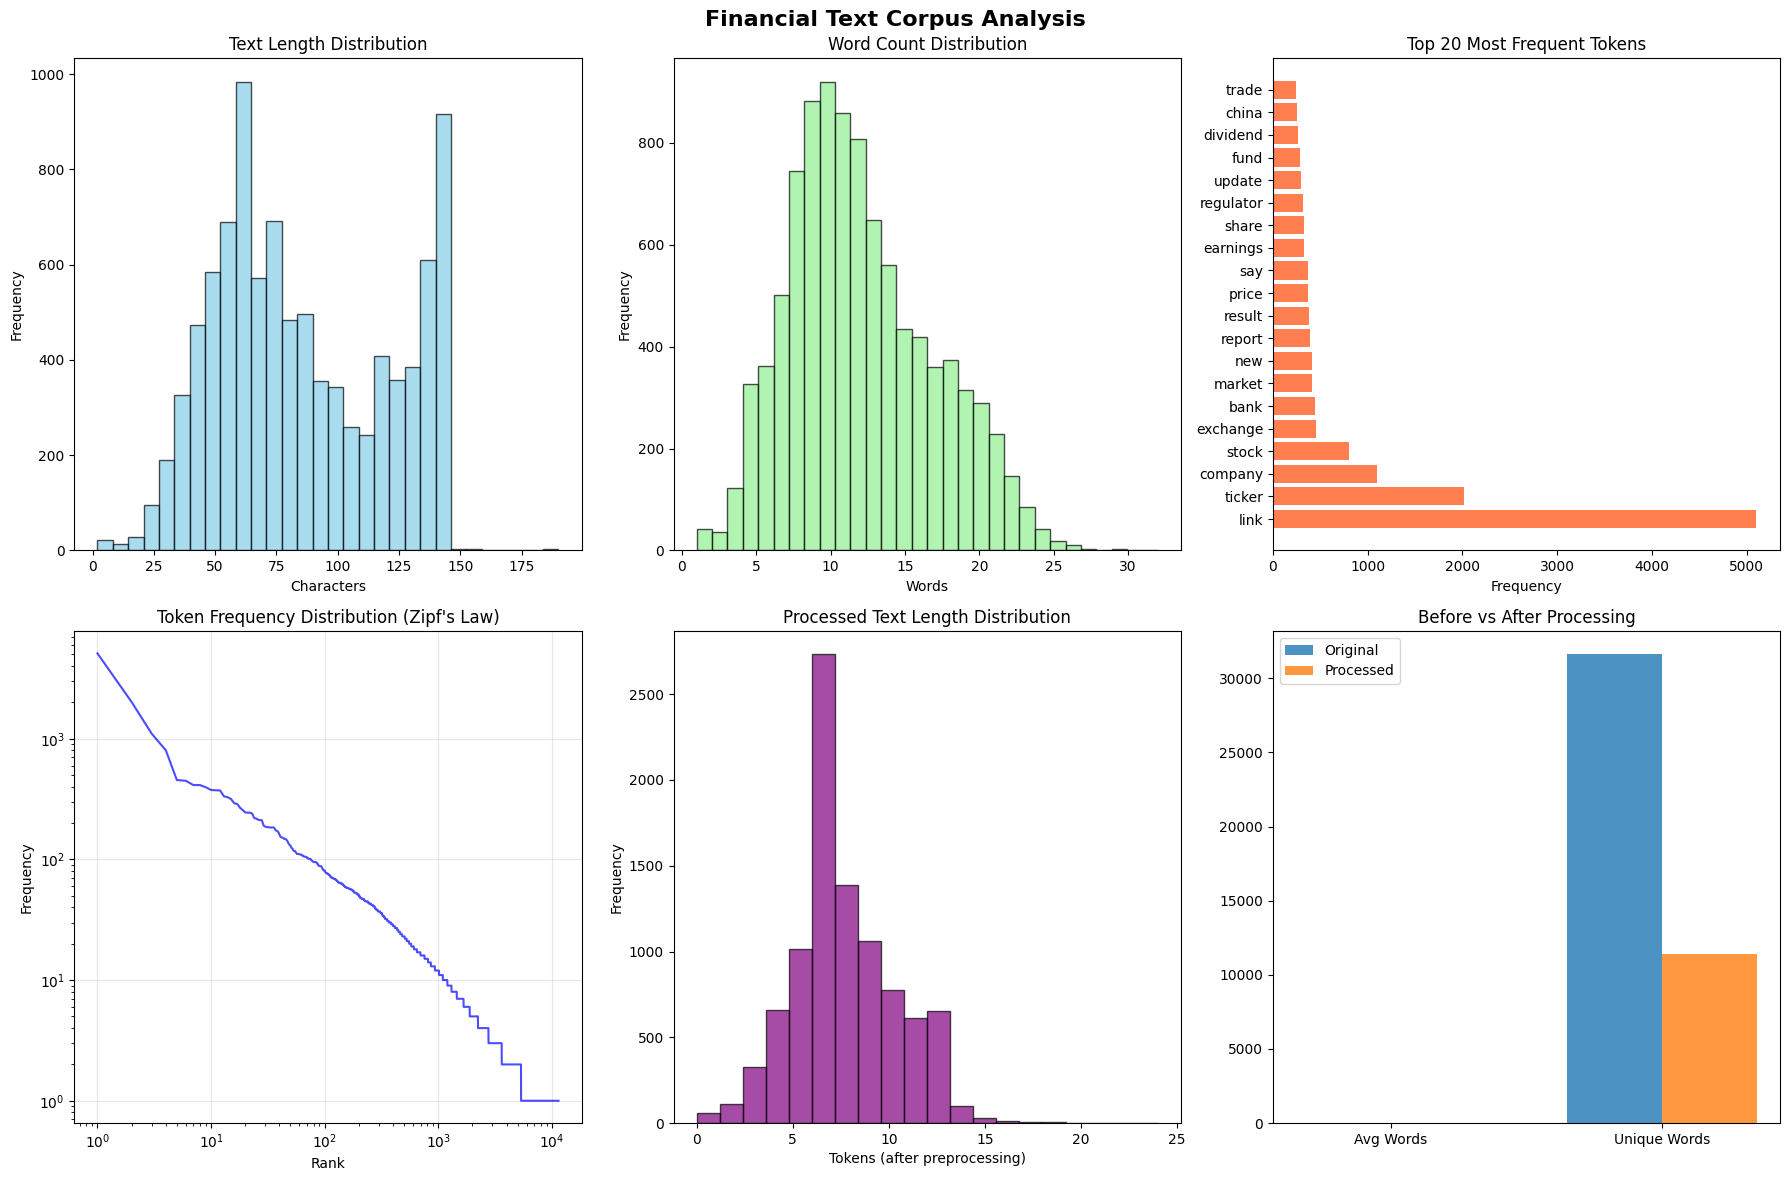

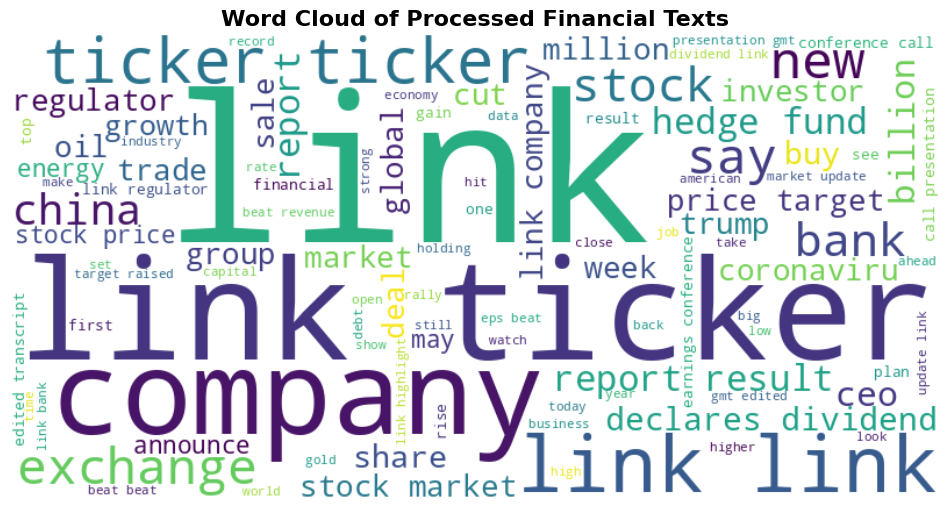


=== PREPROCESSING IMPACT ===
Links replaced: 5095
Tickers replaced: 2014
'Bank of X' patterns replaced: 52
Exchanges replaced: 439
Banks replaced: 260
Funds replaced: 33
Rating agencies replaced: 114
Regulators replaced: 297
Company names replaced: 965
Contractions found and expanded: 281
Special characters/emojis processed: 41588

=== CORPUS SPLITTING ===
Training set: 7634 documents (80.0%)
Validation set: 1909 documents (20.0%)

K-Fold CV: 5 folds prepared
Fold sizes:
  Fold 1: Train=7634, Val=1909
  Fold 2: Train=7634, Val=1909
  Fold 3: Train=7634, Val=1909
  Fold 4: Train=7635, Val=1908
  Fold 5: Train=7635, Val=1908
=== CORPUS OVERVIEW ===
Total documents: 2388
Missing texts: 0

Text Length Statistics:
Mean length: 86.9 characters
Median length: 81.0 characters
Mean word count: 12.3 words

=== PREPROCESSING ===
Total unique tokens: 5250
Total tokens: 18258
Average tokens per document: 7.6

Special Token Counts:
  link: 1286
  rating: 18
  fund: 77
  exchange: 100
  bank: 110
  

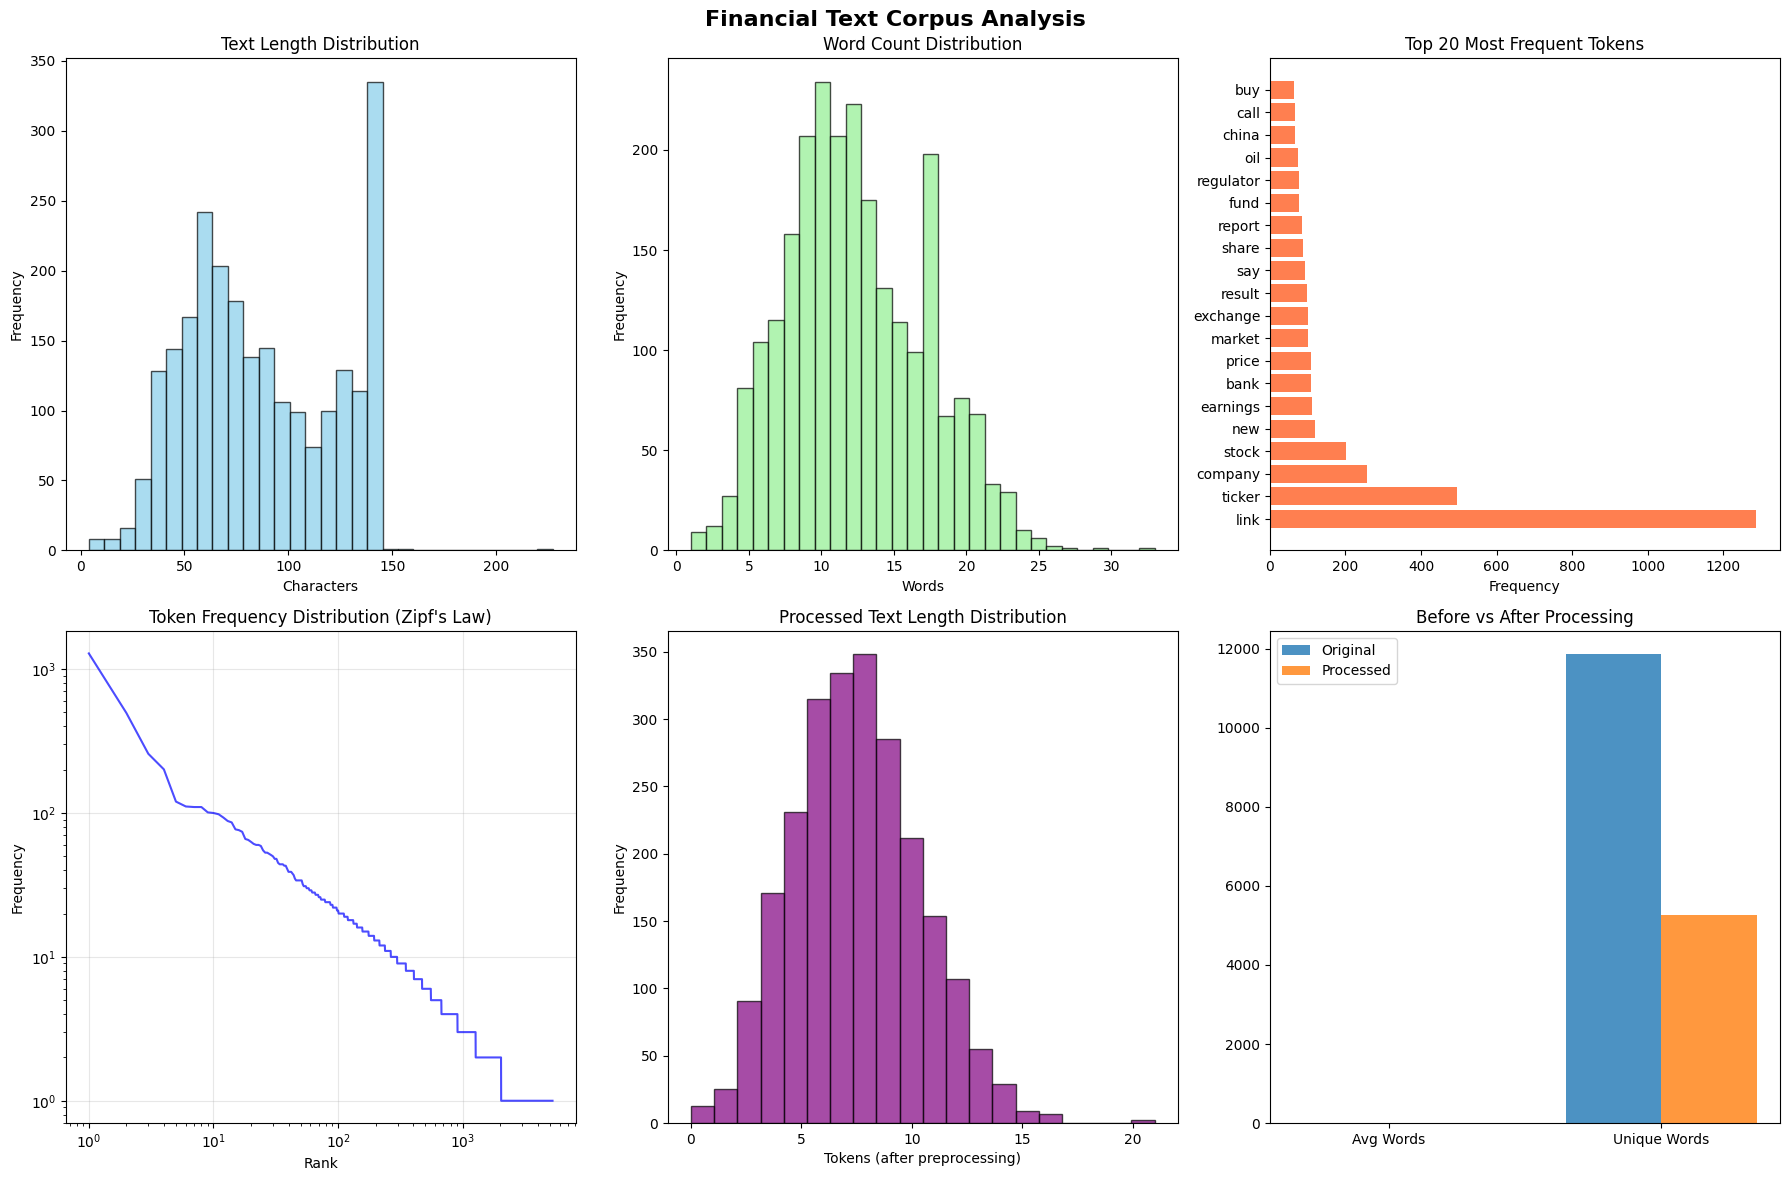

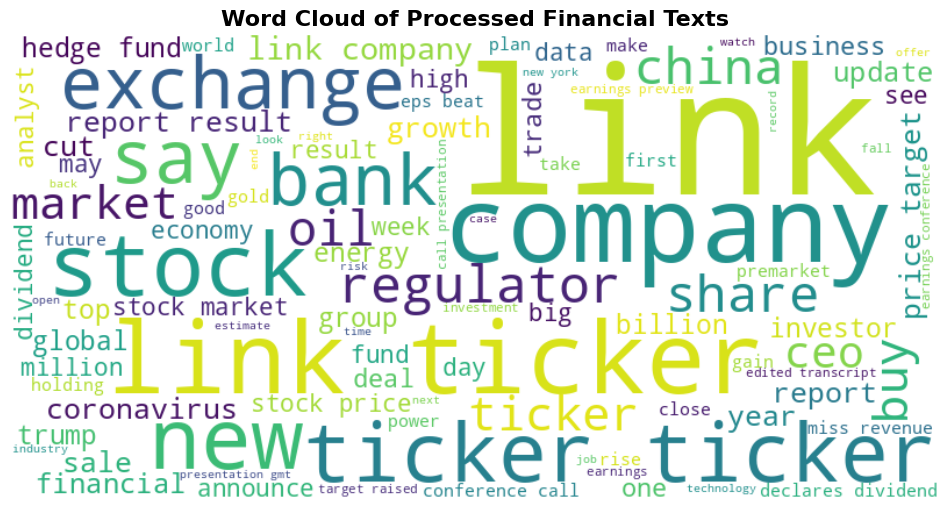


=== PREPROCESSING IMPACT ===
Links replaced: 1285
Tickers replaced: 495
'Bank of X' patterns replaced: 11
Exchanges replaced: 96
Banks replaced: 69
Funds replaced: 13
Rating agencies replaced: 25
Regulators replaced: 72
Company names replaced: 215
Contractions found and expanded: 78
Special characters/emojis processed: 10558

=== PROCESSED SAMPLE ===

Document 0:
Original: $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT
Processed: ticker bank reel expectation beyond meat link
Tokens: ['ticker', 'bank', 'reel', 'expectation', 'beyond', 'meat', 'link']

Document 1:
Original: $CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3
Processed: ticker ticker nomura point booking weakness company company link
Tokens: ['ticker', 'ticker', 'nomura', 'point', 'booking', 'weakness', 'company', 'company', 'link']

Document 2:
Original: $CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN

In [ ]:
    # Run analysis
processed_df, processor = analyze_corpus(df_train)
train_df, val_df, kfold = create_train_validation_split(processed_df)
# Process test dataset
processed_test_df, test_processor = analyze_corpus(df_test)

    # Display processed results
print("\n=== PROCESSED SAMPLE ===")
for i, row in processed_df.head(3).iterrows():
  print(f"\nDocument {i}:")
  print(f"Original: {row['text']}")
  print(f"Processed: {row['processed_text']}")
  print(f"Tokens: {row['tokens']}")


print(f"\n=== PROCESSING SUMMARY ===")
print(f"Total documents processed: {len(processed_df)}")
print(f"Average tokens per document: {processed_df['tokens'].apply(len).mean():.1f}")
print(f"Total unique tokens: {len(set([token for tokens in processed_df['tokens'] for token in tokens]))}")

In [ ]:
import pandas as pd
import nltk
from nltk.stem import SnowballStemmer
!pip install langdetect
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import re

# Set seed for consistent language detection
DetectorFactory.seed = 0

# Download required NLTK data
nltk.download('punkt', quiet=True)

def detect_language(text):
    """
    Detect language of text using langdetect.
    Returns 'en' as default if detection fails.
    """
    try:
        # Clean text for better detection
        clean_text = re.sub(r'[^\w\s]', ' ', text)
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()

        if len(clean_text) < 10:  # Too short for reliable detection
            return 'en'

        lang = detect(clean_text)

        # Map to Snowball stemmer supported languages
        supported_langs = {
            'en': 'english', 'es': 'spanish', 'fr': 'french', 'de': 'german',
            'it': 'italian', 'pt': 'portuguese', 'ru': 'russian', 'nl': 'dutch',
            'sv': 'swedish', 'no': 'norwegian', 'da': 'danish', 'fi': 'finnish',
            'hu': 'hungarian', 'ro': 'romanian', 'ar': 'arabic'
        }

        return supported_langs.get(lang, 'english')

    except (LangDetectException, Exception):
        return 'english'  # Default to English

def stem_tokens(tokens, language='english'):
    """
    Apply Snowball stemming to tokens based on detected language.
    """
    try:
        stemmer = SnowballStemmer(language)
        return [stemmer.stem(token) for token in tokens]
    except:
        # Fallback to English if language not supported
        stemmer = SnowballStemmer('english')
        return [stemmer.stem(token) for token in tokens]

def analyze_corpus_with_stemming(df):
    """
    Enhanced corpus analysis with language detection and stemming.
    """
    processed_data = []

    for idx, row in df.iterrows():
        text = row['text']

        # Your existing preprocessing (assuming you have this function)
        processed_text = preprocess_text(text)  # Your current preprocessing

        # Detect language
        language = detect_language(text)

        # Tokenize (assuming you have this)
        tokens = tokenize_text(processed_text)  # Your current tokenization

        # Apply stemming
        stemmed_tokens = stem_tokens(tokens, language)

        processed_data.append({
            **row.to_dict(),
            'processed_text': processed_text,
            'detected_language': language,
            'tokens': tokens,
            'stemmed_tokens': stemmed_tokens,
            'stemmed_text': ' '.join(stemmed_tokens)
        })

    return pd.DataFrame(processed_data), None

# Alternative: modify your existing tokens
def add_stemming_to_existing(processed_df):
    """
    Add stemming to already processed dataframe.
    """
    processed_df = processed_df.copy()

    # Detect languages
    processed_df['detected_language'] = processed_df['text'].apply(detect_language)

    # Apply stemming
    def apply_stemming(row):
        return stem_tokens(row['tokens'], row['detected_language'])

    processed_df['stemmed_tokens'] = processed_df.apply(apply_stemming, axis=1)
    processed_df['stemmed_text'] = processed_df['stemmed_tokens'].apply(lambda x: ' '.join(x))

    return processed_df

# Usage example:
# If you want to modify your existing processed_df:
stemmed_df = add_stemming_to_existing(processed_df)
stemmed_df_test = add_stemming_to_existing(processed_test_df)


=== CLEANED CORPUS RAW DATA ANALYSIS (stemmed_text) ===

Dataset Overview:
Total documents: 9,543
Missing texts: 0
Empty texts: 8
Duplicate texts: 228

Text Length Statistics:
Characters - Mean: 46.7, Median: 45.0
Words - Mean: 7.6, Median: 7.0
Sentences - Mean: 1.0, Median: 1.0

Content Analysis:
URLs: 0 total in 0 documents (0.0%)
Mentions (@): 0
Hashtags (#): 0
Stock tickers ($): 0 in 0 documents (0.0%)
Numbers: 0
Currency amounts: 0
Special characters: 0
All-caps words: 0


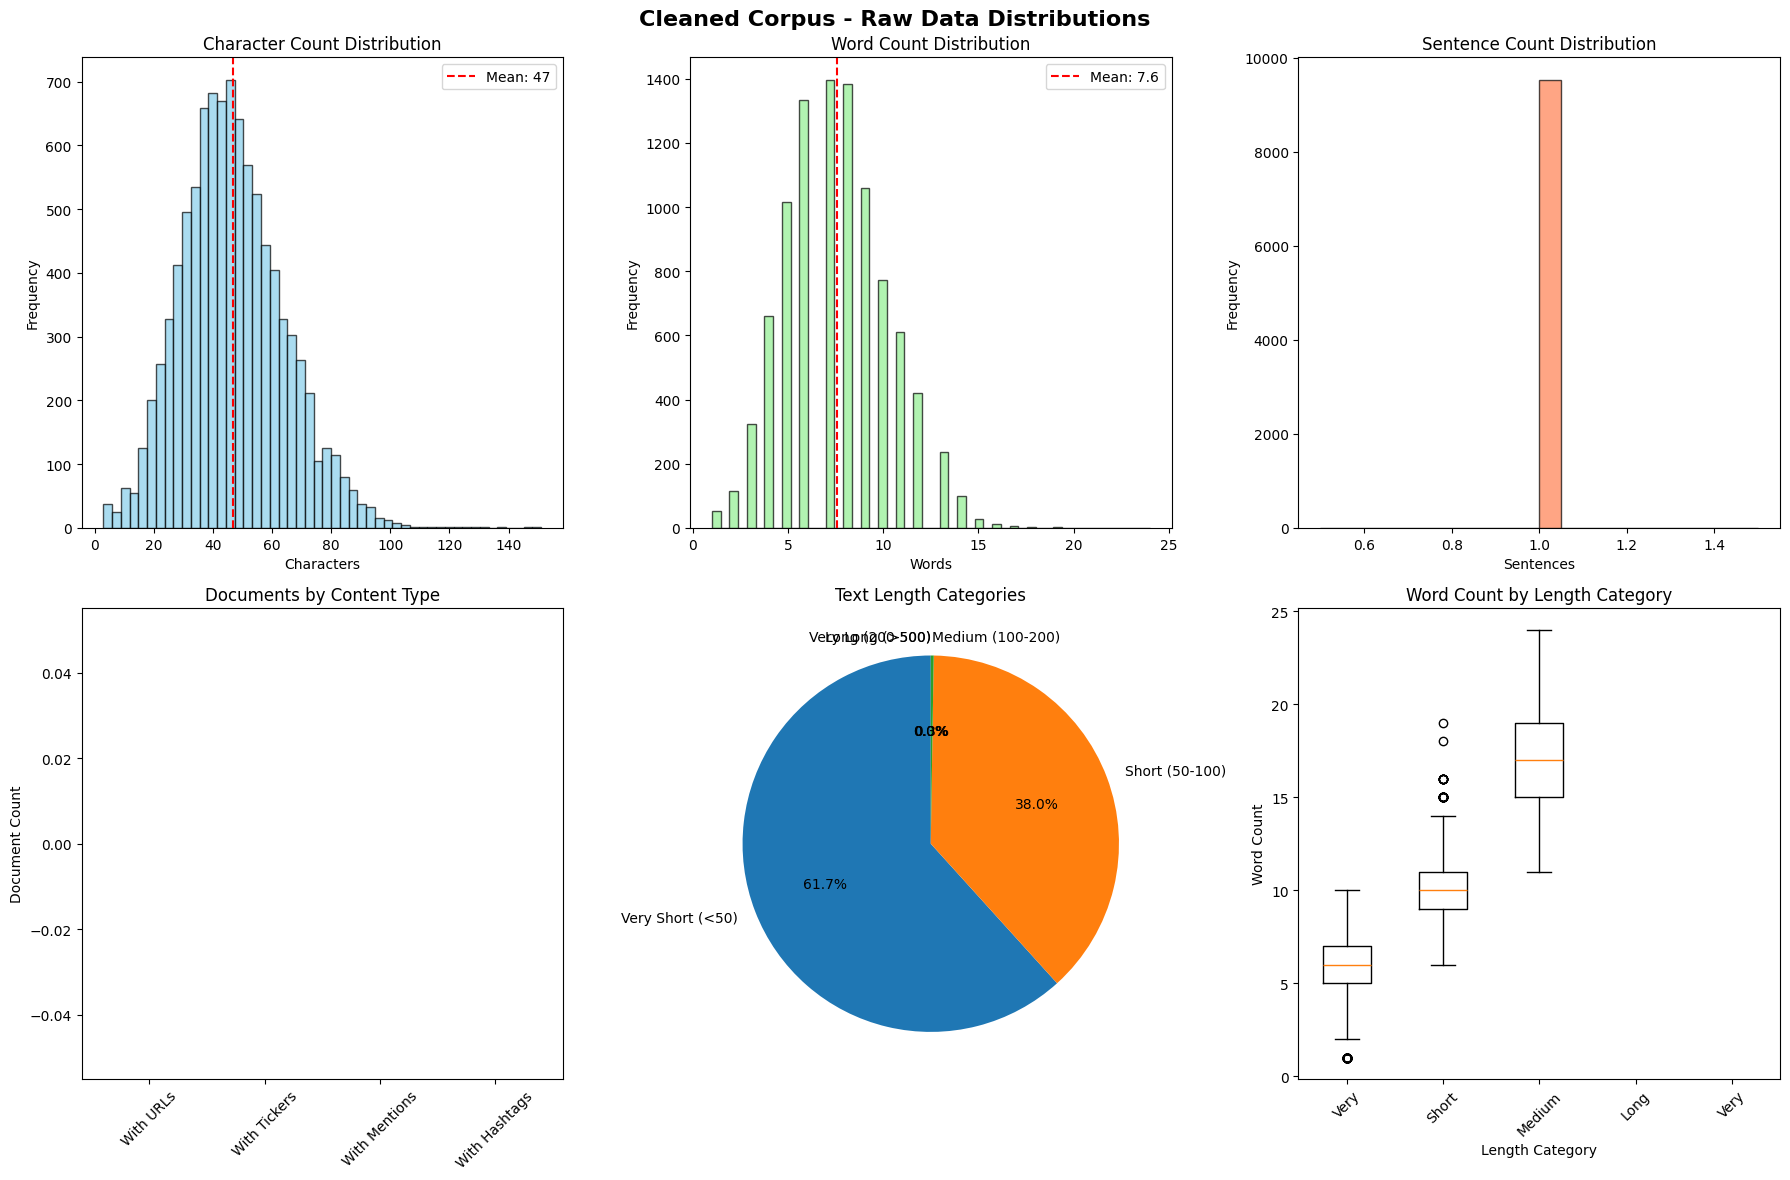


=== RAW VOCABULARY ANALYSIS ===
Total words: 72,112
Unique words: 9,713
Vocabulary richness: 0.135

Top 20 Most Frequent Words:
  link: 5,098 (7.07%)
  ticker: 1,943 (2.69%)
  compani: 1,055 (1.46%)
  stock: 802 (1.11%)
  bank: 458 (0.64%)
  exchang: 455 (0.63%)
  report: 428 (0.59%)
  market: 417 (0.58%)
  new: 413 (0.57%)
  price: 391 (0.54%)
  say: 387 (0.54%)
  result: 378 (0.52%)
  earn: 342 (0.47%)
  share: 326 (0.45%)
  regul: 313 (0.43%)
  updat: 305 (0.42%)
  fund: 303 (0.42%)
  trade: 292 (0.40%)
  buy: 267 (0.37%)
  dividend: 264 (0.37%)

=== FINANCIAL CONTENT ANALYSIS ===

Financial keyword frequency:
  stock: 811
  market: 507
  price: 396
  buy: 320
  trade: 319
  sell: 116
  profit: 76
  bullish: 70
  loss: 42
  bearish: 10
  revenue: 2

=== DATA QUALITY INDICATORS ===
Very short texts (<20 chars): 420 (4.4%)
Very long texts (>500 chars): 0 (0.0%)
Punctuation-heavy texts (>30%): 0 (0.0%)


(                                                   text  label  text_length  \
 0     $BYND - JPMorgan reels in expectations on Beyo...      0           77   
 1     $CCL $RCL - Nomura points to bookings weakness...      0          102   
 2     $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0           94   
 3     $ESS: BTIG Research cuts to Neutral https://t....      0           59   
 4     $FNKO - Funko slides after Piper Jaffray PT cu...      0           71   
 ...                                                 ...    ...          ...   
 9538  The Week's Gainers and Losers on the Stoxx Eur...      2          136   
 9539  Tupperware Brands among consumer gainers; Unil...      2           67   
 9540  vTv Therapeutics leads healthcare gainers; Myo...      2           89   
 9541    WORK, XPO, PYX and AMKR among after hour movers      2           47   
 9542             YNDX, I, QD and OESX among tech movers      2           38   
 
       word_count                     

In [ ]:
raw_corpus_analysis(stemmed_df, text_column='stemmed_text', dataset_name='Cleaned Corpus')

# Feature Extraction

##BOW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Apply BoW to stemmed_text
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(stemmed_df['stemmed_text'])

print("BoW shape:", X_bow.shape)


BoW shape: (9543, 9786)


##Glove (Additional)

In [ ]:
import numpy as np
import urllib.request
import zipfile
import os

# Download pre-trained GloVe embeddings (100d)
def download_glove():
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    if not os.path.exists("glove.6B.100d.txt"):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(url, "glove.6B.zip")
        with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
            zip_ref.extract("glove.6B.100d.txt")
        os.remove("glove.6B.zip")

# Load GloVe embeddings
def load_glove_embeddings(file_path="glove.6B.100d.txt"):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Convert text to GloVe vector (average of word embeddings)
def text_to_glove_vector(text, embeddings, vector_size=100):
    words = text.split()
    word_vectors = [embeddings[word] for word in words if word in embeddings]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

# Main execution
download_glove()
glove_embeddings = load_glove_embeddings()

# Apply to your data
X_glove = np.array([text_to_glove_vector(text, glove_embeddings)
                   for text in stemmed_df['stemmed_text']])

print("GloVe shape:", X_glove.shape)
print("Vocabulary size:", len(glove_embeddings))

GloVe shape: (9543, 100)
Vocabulary size: 400000


##Bert (Transformer)

In [ ]:
stemmed_df.head()

,text,label,text_length,word_count,cleaned_text,tokens,processed_text,detected_language,stemmed_tokens,stemmed_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77,10,ticker - bank reels in expectations on Bey...,"[ticker, bank, reel, expectation, beyond, meat...",ticker bank reel expectation beyond meat link,english,"[ticker, bank, reel, expect, beyond, meat, link]",ticker bank reel expect beyond meat link
1,$CCL $RCL - Nomura points to bookings weakness...,0,102,14,ticker ticker - Nomura points to bookings ...,"[ticker, ticker, nomura, point, booking, weakn...",ticker ticker nomura point booking weakness co...,english,"[ticker, ticker, nomura, point, book, weak, co...",ticker ticker nomura point book weak compani c...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94,14,"ticker - Cemex cut at bank , J.P. Morgan on...","[ticker, cemex, cut, bank, morgan, weak, build...",ticker cemex cut bank morgan weak building out...,english,"[ticker, cemex, cut, bank, morgan, weak, build...",ticker cemex cut bank morgan weak build outloo...
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59,7,ticker BTIG Research cuts to Neutral link,"[ticker, btig, research, cut, neutral, link]",ticker btig research cut neutral link,english,"[ticker, btig, research, cut, neutral, link]",ticker btig research cut neutral link
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71,10,ticker - Funko slides after Piper Jaffray PT...,"[ticker, funko, slide, piper, jaffray, cut, link]",ticker funko slide piper jaffray cut link,english,"[ticker, funko, slide, piper, jaffray, cut, link]",ticker funko slide piper jaffray cut link


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm  # Optional: for progress bar
import pickle

# Load tokenizer & model once
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function: encode text to sequence of token embeddings
def encode_text_to_bert_sequence(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=False, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.squeeze(0).cpu()  # Shape: (seq_len, 768)

# Encode and store all BERT token sequences + lengths
bert_sequences = []
sequence_lengths = []

print("🔄 Encoding texts with BERT...")
for text in tqdm(stemmed_df['text']):
    embeddings = encode_text_to_bert_sequence(text)
    bert_sequences.append(embeddings)
    sequence_lengths.append(embeddings.size(0))

# Optionally save for future use
with open("bert_sequences.pkl", "wb") as f:
    pickle.dump((bert_sequences, sequence_lengths), f)

print(f"✅ BERT token sequences saved — total: {len(bert_sequences)}")


🔄 Encoding texts with BERT...


100%|██████████| 9543/9543 [30:42<00:00,  5.18it/s]


✅ BERT token sequences saved — total: 9543


# Modelling and Evaluation

## KNN

📊 KNN with Bag-of-Words (5-Fold CV) Results:

📁 Fold 1 Metrics:

📁 Fold 2 Metrics:

📁 Fold 3 Metrics:

📁 Fold 4 Metrics:

📁 Fold 5 Metrics:

📈 AVERAGE CROSS-VALIDATION SCORES:
Accuracy      : 0.6868
Precision     : 0.6186
Recall        : 0.4456
F1-Score      : 0.4594


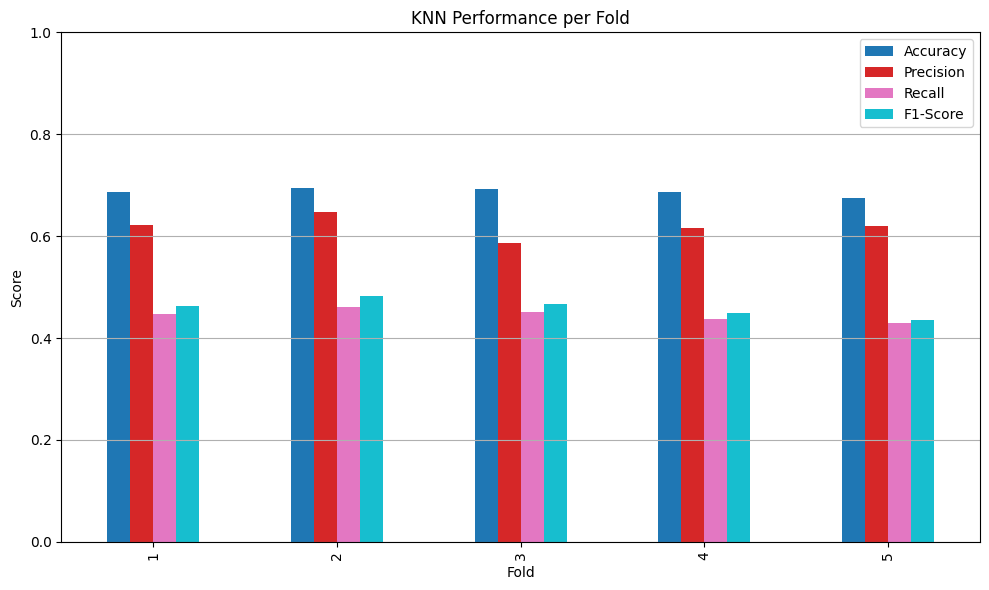

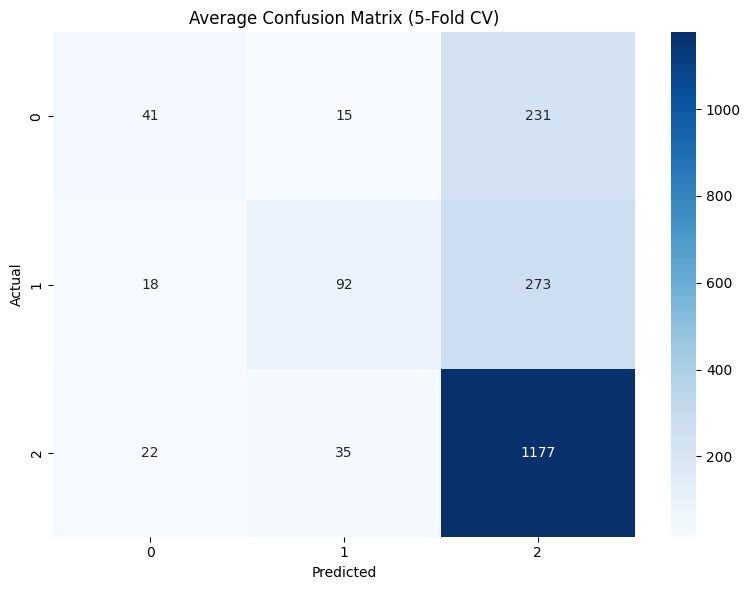

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# 1. BoW Vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stemmed_df['stemmed_text'])

# 2. Encode Labels
label_col = 'label'  # e.g. 'category'
le = LabelEncoder()
y = le.fit_transform(stemmed_df[label_col])
class_names = le.classes_

# 3. Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Prepare metrics storage
acc_list, prec_list, rec_list, f1_list = [], [], [], []
conf_matrices = []

print("📊 KNN with Bag-of-Words (5-Fold CV) Results:")

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Metrics
    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    rec_list.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    f1_list.append(f1_score(y_test, y_pred, average='macro', zero_division=0))
    conf_matrices.append(confusion_matrix(y_test, y_pred, labels=range(len(class_names))))

    print(f"\n📁 Fold {fold} Metrics:")

# 5. Summary of Scores
print("\n📈 AVERAGE CROSS-VALIDATION SCORES:")
print(f"Accuracy      : {np.mean(acc_list):.4f}")
print(f"Precision     : {np.mean(prec_list):.4f}")
print(f"Recall        : {np.mean(rec_list):.4f}")
print(f"F1-Score      : {np.mean(f1_list):.4f}")

# 6. Plot Metric Trends
metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': acc_list,
    'Precision': prec_list,
    'Recall': rec_list,
    'F1-Score': f1_list
})

metrics_df.set_index('Fold').plot(kind='bar', figsize=(10, 6), colormap='tab10', title='KNN Performance per Fold')
plt.ylim(0, 1)
plt.ylabel("Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 7. Confusion Matrix (average)
avg_cm = np.mean(conf_matrices, axis=0).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Average Confusion Matrix (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## LSTM

###Bow

In [ ]:
# 0. Imports & reproducibility ----------------------------------------------
import re, random, numpy as np, pandas as pd
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Tiny regex tokenizer -----------------------------------------------------
def simple_tokenizer(text: str):
    """Lower-case, keep only word chars, split on whitespace."""
    return re.findall(r"\b\w+\b", text.lower())

# ---------------------------------------------------------------------------
# 2. Tokenise the corpus (stemmed_df must already exist in your namespace)
# ---------------------------------------------------------------------------
token_lists = [simple_tokenizer(t) for t in stemmed_df["stemmed_text"]]

# -- Drop any rows that became empty after tokenisation
non_empty_mask = [len(toks) > 0 for toks in token_lists]
stemmed_df = stemmed_df.loc[non_empty_mask].reset_index(drop=True)
token_lists = [toks for toks in token_lists if toks]   # all lengths ≥ 1 now

# 3. Build vocabulary (index 0 reserved for PAD) -----------------------------
counter = Counter(chain.from_iterable(token_lists))
vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common())}
PAD_IDX = 0
vocab_size = len(vocab) + 1          # +1 for PAD

# 4. Encode sequences & lengths ---------------------------------------------
sequences = [[vocab.get(tok, PAD_IDX) for tok in toks] for toks in token_lists]
lengths = np.array([len(seq) for seq in sequences])
max_len = lengths.max()

X = np.zeros((len(sequences), max_len), dtype=np.int64)  # PADDED with 0s
for i, seq in enumerate(sequences):
    X[i, :len(seq)] = seq

# 5. Encode labels -----------------------------------------------------------
le = LabelEncoder()
y = le.fit_transform(stemmed_df["label"])         # adjust column name as needed
num_classes = len(le.classes_)

# 6. Dataset / Dataloader ----------------------------------------------------
class TextDataset(Dataset):
    def __init__(self, X, y, lengths):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
        self.lengths = torch.tensor(lengths, dtype=torch.long)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.lengths[idx]

dataset = TextDataset(X, y, lengths)

# 7. LSTM model (packed sequences) -------------------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        return self.fc(h_n[-1])

# 8. 5-fold training & evaluation -------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
acc_list, prec_list, rec_list, f1_list = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), 1):
    print(f"\n🌀 Fold {fold}")

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, val_idx),   batch_size=32)

    model = LSTMClassifier(
        vocab_size=vocab_size,
        embed_dim=100,
        hidden_dim=64,
        output_dim=num_classes,
        pad_idx=PAD_IDX,
    ).to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # ----- Training loop -----
    for epoch in range(15):                           # raise if you need
        model.train()
        for Xb, yb, lb in train_loader:
            Xb, yb, lb = Xb.to(device), yb.to(device), lb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(Xb, lb), yb)
            loss.backward()
            optimizer.step()

    # ----- Validation -----
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for Xb, yb, lb in val_loader:
            preds = torch.argmax(model(Xb.to(device), lb.to(device)), dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_targets.extend(yb.numpy())

    acc_list.append(accuracy_score(all_targets, all_preds))
    prec_list.append(precision_score(all_targets, all_preds, average="macro", zero_division=0))
    rec_list.append(recall_score(all_targets, all_preds, average="macro", zero_division=0))
    f1_list.append(f1_score(all_targets, all_preds, average="macro", zero_division=0))

# 9. Report ------------------------------------------------------------------
print("\n📊 LSTM Classifier Results (5-Fold):")
print(f"Accuracy : {np.mean(acc_list):.4f}")
print(f"Precision: {np.mean(prec_list):.4f}")
print(f"Recall   : {np.mean(rec_list):.4f}")
print(f"F1-Score : {np.mean(f1_list):.4f}")



🌀 Fold 1

🌀 Fold 2

🌀 Fold 3

🌀 Fold 4

🌀 Fold 5

📊 LSTM Classifier Results (5-Fold):
Accuracy : 0.7507
Precision: 0.6669
Recall   : 0.6589
F1-Score : 0.6618


In [ ]:
# ---------------------------------------------------------------------------
#  A. Re-fit the final model on *all* training data  (optional but common)
# ---------------------------------------------------------------------------
# If you want the very last fold’s weights instead, you can skip this section.
full_loader = DataLoader(dataset, batch_size=32, shuffle=True)

model_all = LSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=100,
    hidden_dim=64,
    output_dim=num_classes,
    pad_idx=PAD_IDX,
).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_all.parameters(), lr=1e-3)

EPOCHS = 15
for epoch in range(EPOCHS):
    model_all.train()
    for Xb, yb, lb in full_loader:
        Xb, yb, lb = Xb.to(device), yb.to(device), lb.to(device)
        optimizer.zero_grad()
        loss = criterion(model_all(Xb, lb), yb)
        loss.backward()
        optimizer.step()

# ---------------------------------------------------------------------------
#  B. Build the test tensor
# ---------------------------------------------------------------------------
def encode_dataframe(df, text_col):
    """Tokenise, map to ids, pad; returns X, lengths."""
    token_lists = [simple_tokenizer(t) for t in df[text_col]]
    # ensure every sample has ≥1 token
    token_lists = [t if t else ["<PAD>"] for t in token_lists]

    sequences = [[vocab.get(tok, PAD_IDX) for tok in toks] for toks in token_lists]
    lengths = np.array([len(seq) for seq in sequences])
    max_len = lengths.max()

    X = np.zeros((len(sequences), max_len), dtype=np.int64)
    for i, seq in enumerate(sequences):
        X[i, :len(seq)] = seq
    return X, lengths

X_test, lengths_test = encode_dataframe(stemmed_df_test, "stemmed_text")

class InferenceDataset(Dataset):
    def __init__(self, X, lengths):
        self.X = torch.tensor(X, dtype=torch.long)
        self.lengths = torch.tensor(lengths, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.lengths[idx]          # no label

test_loader = DataLoader(InferenceDataset(X_test, lengths_test), batch_size=32)

# ---------------------------------------------------------------------------
#  C. Predict
# ---------------------------------------------------------------------------
model_all.eval()
all_preds = []
with torch.no_grad():
    for Xb, lb in test_loader:
        preds = torch.argmax(model_all(Xb.to(device), lb.to(device)), dim=1)
        all_preds.extend(preds.cpu().numpy())

# Optional: get class probabilities instead of argmax
# softmax = torch.nn.Softmax(dim=1)
# probs = []
# with torch.no_grad():
#     for Xb, lb in test_loader:
#         p = softmax(model_all(Xb.to(device), lb.to(device))).cpu().numpy()
#         probs.append(p)
# probs = np.concatenate(probs, axis=0)

# ---------------------------------------------------------------------------
#  D. Attach to the DataFrame
# ---------------------------------------------------------------------------
stemmed_df_test["predicted_idx"]   = all_preds
stemmed_df_test["predicted_label"] = le.inverse_transform(all_preds)

print(stemmed_df_test[["text", "predicted_label"]].head())


KeyboardInterrupt: 

### Glove

In [ ]:
# LSTM with GloVe - preserving sequence structure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import re
from collections import Counter

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Tokenize texts (assuming glove_embeddings already loaded)
def simple_tokenizer(text: str):
    return re.findall(r"\b\w+\b", text.lower())

token_lists = [simple_tokenizer(t) for t in stemmed_df["stemmed_text"]]
non_empty_mask = [len(toks) > 0 for toks in token_lists]
stemmed_df = stemmed_df.loc[non_empty_mask].reset_index(drop=True)
token_lists = [toks for toks in token_lists if toks]

# 2. Convert word sequences to GloVe vector sequences
def tokens_to_glove_sequence(tokens, embeddings, embed_dim=100):
    vectors = []
    for token in tokens:
        if token in embeddings:
            vectors.append(embeddings[token])
        else:
            vectors.append(np.zeros(embed_dim))  # UNK token
    return np.array(vectors)

# Create sequences of GloVe vectors
glove_sequences = [tokens_to_glove_sequence(tokens, glove_embeddings)
                  for tokens in token_lists]
lengths = [len(seq) for seq in glove_sequences]

# 3. Encode labels
le = LabelEncoder()
y = le.fit_transform(stemmed_df["label"])
num_classes = len(le.classes_)

# 4. Dataset for variable-length sequences
class GloVeSequenceDataset(Dataset):
    def __init__(self, sequences, labels, lengths):
        self.sequences = sequences
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (torch.tensor(self.sequences[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.long),
                self.lengths[idx])

def collate_fn(batch):
    sequences, labels, lengths = zip(*batch)
    # Pad sequences to same length
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, torch.stack(labels), torch.tensor(lengths)

dataset = GloVeSequenceDataset(glove_sequences, y, lengths)

# 5. LSTM Model for GloVe sequences
class GloVeLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, lengths):
        # Pack sequences for efficient processing
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)

        # Use last hidden state
        output = self.dropout(h_n[-1])
        return self.fc(output)

# 6. 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
acc_list, prec_list, rec_list, f1_list = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), 1):
    print(f"\n🌀 Fold {fold}")

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32,
                             shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=32,
                           collate_fn=collate_fn)

    model = GloVeLSTMClassifier(
        input_dim=100,  # GloVe dimension
        hidden_dim=64,
        output_dim=num_classes,
        num_layers=2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
    for epoch in range(15):
        model.train()
        for batch_X, batch_y, batch_lengths in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            batch_lengths = batch_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X, batch_lengths)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y, batch_lengths in val_loader:
            batch_X = batch_X.to(device)
            batch_lengths = batch_lengths.to(device)
            outputs = model(batch_X, batch_lengths)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_targets.extend(batch_y.numpy())

    # Metrics
    acc_list.append(accuracy_score(all_targets, all_preds))
    prec_list.append(precision_score(all_targets, all_preds, average="macro", zero_division=0))
    rec_list.append(recall_score(all_targets, all_preds, average="macro", zero_division=0))
    f1_list.append(f1_score(all_targets, all_preds, average="macro", zero_division=0))

# Results
print("\n📊 GloVe + LSTM Classifier Results (5-Fold):")
print(f"Accuracy : {np.mean(acc_list):.4f}")
print(f"Precision: {np.mean(prec_list):.4f}")
print(f"Recall   : {np.mean(rec_list):.4f}")
print(f"F1-Score : {np.mean(f1_list):.4f}")


🌀 Fold 1

🌀 Fold 2

🌀 Fold 3

🌀 Fold 4

🌀 Fold 5

📊 GloVe + LSTM Classifier Results (5-Fold):
Accuracy : 0.7525
Precision: 0.6729
Recall   : 0.6372
F1-Score : 0.6484


###Bert

In [ ]:
# === Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import pickle

# === Settings ===
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load BERT token embeddings ===
with open("bert_sequences.pkl", "rb") as f:
    bert_sequences, sequence_lengths = pickle.load(f)

# === Load stemmed_df (must already be defined) ===
# stemmed_df = pd.read_csv("your_cleaned_text_file.csv")  # Uncomment if needed

# === Smart alignment across all data sources ===
min_len = min(len(bert_sequences), len(sequence_lengths), len(stemmed_df))

bert_sequences = bert_sequences[:min_len]
sequence_lengths = sequence_lengths[:min_len]
stemmed_df = stemmed_df.iloc[:min_len].reset_index(drop=True)

# === Encode labels ===
le = LabelEncoder()
y = le.fit_transform(stemmed_df["label"])
num_classes = len(le.classes_)

assert len(y) == len(bert_sequences) == len(sequence_lengths), "✅ All aligned correctly!"

# === Dataset & Collate Function ===
class BERTSequenceDataset(Dataset):
    def __init__(self, sequences, labels, lengths):
        self.sequences = sequences
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], torch.tensor(self.labels[idx], dtype=torch.long), self.lengths[idx]

def collate_fn_bert(batch):
    sequences, labels, lengths = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, torch.stack(labels), torch.tensor(lengths)

# === Model ===
class BERTLSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=64, output_dim=2, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        out = self.dropout(h_n[-1])  # last layer's hidden state
        return self.fc(out)

# === Cross-Validation ===
dataset = BERTSequenceDataset(bert_sequences, y, sequence_lengths)
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

acc_list, prec_list, rec_list, f1_list = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), 1):
    print(f"\n🔁 Fold {fold}")

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True, collate_fn=collate_fn_bert)
    val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=16, collate_fn=collate_fn_bert)

    model = BERTLSTMClassifier(output_dim=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)

    # === Training ===
    for epoch in range(15):
        model.train()
        for batch_X, batch_y, batch_lengths in train_loader:
            batch_X, batch_y, batch_lengths = batch_X.to(device), batch_y.to(device), batch_lengths.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X, batch_lengths)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # === Validation ===
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y, batch_lengths in val_loader:
            batch_X, batch_lengths = batch_X.to(device), batch_lengths.to(device)
            outputs = model(batch_X, batch_lengths)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_targets.extend(batch_y.numpy())

    # === Metrics ===
    acc_list.append(accuracy_score(all_targets, all_preds))
    prec_list.append(precision_score(all_targets, all_preds, average="macro", zero_division=0))
    rec_list.append(recall_score(all_targets, all_preds, average="macro", zero_division=0))
    f1_list.append(f1_score(all_targets, all_preds, average="macro", zero_division=0))

# === Final Report ===
print("\n📊 BERT + LSTM Classifier Results (5-Fold):")
print(f"Accuracy : {np.mean(acc_list):.4f}")
print(f"Precision: {np.mean(prec_list):.4f}")
print(f"Recall   : {np.mean(rec_list):.4f}")
print(f"F1-Score : {np.mean(f1_list):.4f}")



🔁 Fold 1

🔁 Fold 2

🔁 Fold 3

🔁 Fold 4

🔁 Fold 5

📊 BERT + LSTM Classifier Results (5-Fold):
Accuracy : 0.8035
Precision: 0.7411
Recall   : 0.7158
F1-Score : 0.7261
